# Ejercicio 9 - Clasificación de Vinos con Red Neuronal

Se ha realizado un análisis químico a tres tipos distintos de vinos producidos en una misma región de Italia.
El número de muestras considerado es el siguiente:

    Tipo 1 ➔ 59 muestras, Tipo 2 ➔ 71 muestras, Tipo 3 ➔48 muestras

El archivo vinos.csv permite observar los resultados de este análisis. Cada fila representa una muestra
distinta y está formada, en primer lugar, por el número del tipo al cual pertenece el vino analizado seguido
por los 13 atributos que lo caracterizan.

### a) 
Entrene una red neuronal formada por una única neurona para clasificar los vinos de Tipo 1

Realice 30 ejecuciones independientes utilizando el 50%, 60%, 70%, 80% y 90% de los ejemplos como
entrenamiento y el resto como testeo. Para cada porcentaje, indique la cantidad promedio de ejemplos
correctamente clasificados en entrenamiento y en testeo. Calcule también el promedio y el desvío de la
cantidad de iteraciones realizadas.

Utilice un máximo de 400 iteraciones y velocidades de aprendizaje 0.1, 0.2 y 0.3.
Analice los resultados obtenidos utilizando:

i. Función de activación 'sigmoid' y función de costo 'ECM' (error cuadrático medio)

ii. Función de activación 'sigmoid' y función de costo 'EC_binaria' (entropía cruzada binaria)

iii. Función de activación 'tanh' y función de costo 'ECM' (error cuadrático medio)

## Paso 1: Importar librerías y cargar datos

In [6]:
import numpy as np
import pandas as pd
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
datos = pd.read_csv(r'..\..\Datos\Vinos.csv', delimiter=';')
print(f"Dimensiones del dataset: {datos.shape}")
print(f"\nPrimeras 5 filas:")
print(datos.head())

# Información sobre las clases
print(f"\nDistribución de clases:")
print(datos['Class'].value_counts().sort_index())

Dimensiones del dataset: (178, 14)

Primeras 5 filas:
   Class  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
0      1    14.23        1.71  2.43               15.6        127   
1      1    13.20        1.78  2.14               11.2        100   
2      1    13.16        2.36  2.67               18.6        101   
3      1    14.37        1.95  2.50               16.8        113   
4      1    13.24        2.59  2.87               21.0        118   

   Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color intensity   Hue  OD280/OD315  Proline  
0             5.64  1.04         3.92     1065  
1     

## Paso 2: Preparar datos para clasificación binaria (Tipo 1 vs. Resto)

In [7]:
# Separar características (X) y etiquetas (T)
X = datos.iloc[:, 1:].values  # Todas las columnas excepto la primera (Class)
T_original = datos.iloc[:, 0].values  # Primera columna (Class)

# Convertir a problema binario: Tipo 1 = 1, Resto = -1 (para tanh) o 0 (para sigmoid)
T = np.where(T_original == 1, 1, -1)

print(f"Forma de X: {X.shape}")
print(f"Forma de T: {T.shape}")
print(f"Etiquetas únicas en T: {np.unique(T)}")
print(f"Cantidad de vinos Tipo 1: {np.sum(T == 1)}")
print(f"Cantidad de vinos otros tipos: {np.sum(T == -1)}")

# Normalizar características (importante para el gradiente)
scaler = preprocessing.StandardScaler()
X_normalized = scaler.fit_transform(X)
print(f"\nDatos normalizados (media ≈ 0, std ≈ 1)")

Forma de X: (178, 13)
Forma de T: (178,)
Etiquetas únicas en T: [-1  1]
Cantidad de vinos Tipo 1: 59
Cantidad de vinos otros tipos: 119

Datos normalizados (media ≈ 0, std ≈ 1)


## Paso 3: Implementar la clase Neurona con Gradiente Descendente

In [8]:
class NeuronaGradiente:
    """
    Neurona con descenso de gradiente para clasificación binaria.
    
    Parámetros:
    -----------
    alpha : float
        Tasa de aprendizaje (0.0 a 1.0)
    n_iter : int
        Número máximo de iteraciones
    cotaE : float
        Criterio de parada (diferencia mínima de error entre iteraciones)
    FUN : str
        Función de activación: 'sigmoid' o 'tanh'
    COSTO : str
        Función de costo: 'ECM' (error cuadrático medio) o 'EC_binaria' (entropía cruzada binaria)
    random_state : int
        Semilla para reproducibilidad
    """
    
    def __init__(self, alpha=0.1, n_iter=400, cotaE=1e-6, FUN='sigmoid', 
                 COSTO='ECM', random_state=None):
        self.alpha = alpha
        self.n_iter = n_iter
        self.cotaE = cotaE
        self.FUN = FUN
        self.COSTO = COSTO
        self.random_state = random_state
        
    def _sigmoid(self, x):
        """Función sigmoide"""
        return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))
    
    def _tanh(self, x):
        """Función tangente hiperbólica"""
        return np.tanh(x)
    
    def _activation(self, x):
        """Aplica la función de activación"""
        if self.FUN == 'sigmoid':
            return self._sigmoid(x)
        elif self.FUN == 'tanh':
            return self._tanh(x)
        
    def _activation_derivative(self, y):
        """Calcula la derivada de la función de activación"""
        if self.FUN == 'sigmoid':
            return y * (1 - y)
        elif self.FUN == 'tanh':
            return 1 - y**2
    
    def _compute_cost(self, T, y):
        """Calcula el costo según la función especificada"""
        if self.COSTO == 'ECM':
            # Error cuadrático medio
            return np.mean((T - y) ** 2)
        elif self.COSTO == 'EC_binaria':
            # Entropía cruzada binaria (solo para sigmoid con etiquetas 0/1)
            epsilon = 1e-15  # Para evitar log(0)
            y = np.clip(y, epsilon, 1 - epsilon)
            return -np.mean(T * np.log(y) + (1 - T) * np.log(1 - y))
    
    def fit(self, X, T):
        """
        Entrenar la neurona
        
        Parámetros:
        -----------
        X : array, shape = [n_samples, n_features]
            Datos de entrenamiento
        T : array, shape = [n_samples]
            Etiquetas objetivo
        """
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        # Inicializar pesos y bias aleatoriamente
        n_features = X.shape[1]
        self.W = np.random.uniform(-0.5, 0.5, n_features)
        self.b = np.random.uniform(-0.5, 0.5)
        
        # Lista para almacenar el histórico de costos
        self.costs_ = []
        self.n_iter_ = 0
        
        # Entrenamiento
        cost_prev = float('inf')
        
        for i in range(self.n_iter):
            # Forward pass: calcular salidas para todos los ejemplos
            netas = np.dot(X, self.W) + self.b
            y = self._activation(netas)
            
            # Calcular error
            errors = T - y
            
            # Calcular costo
            cost = self._compute_cost(T, y)
            self.costs_.append(cost)
            
            # Verificar criterio de parada
            if np.abs(cost_prev - cost) < self.cotaE:
                self.n_iter_ = i + 1
                break
            
            cost_prev = cost
            
            # Backward pass: calcular gradientes
            if self.COSTO == 'ECM':
                # Para ECM, necesitamos la derivada de la función de activación
                deriv = self._activation_derivative(y)
                # Gradientes
                grad_W = -np.dot(X.T, errors * deriv) / len(T)
                grad_b = -np.sum(errors * deriv) / len(T)
            elif self.COSTO == 'EC_binaria':
                # Para entropía cruzada binaria con sigmoid, el gradiente se simplifica
                # Gradientes (sin necesidad de la derivada de la activación)
                grad_W = -np.dot(X.T, errors) / len(T)
                grad_b = -np.sum(errors) / len(T)
            
            # Actualizar pesos y bias
            self.W -= self.alpha * grad_W
            self.b -= self.alpha * grad_b
            
            self.n_iter_ = i + 1
        
        return self
    
    def predict(self, X):
        """
        Predecir clases para los datos de entrada
        
        Parámetros:
        -----------
        X : array, shape = [n_samples, n_features]
            Datos de entrada
            
        Retorna:
        --------
        y_pred : array, shape = [n_samples]
            Clases predichas
        """
        netas = np.dot(X, self.W) + self.b
        y = self._activation(netas)
        
        # Umbralizar según la función de activación
        if self.FUN == 'sigmoid':
            return np.where(y >= 0.5, 1, 0)
        elif self.FUN == 'tanh':
            return np.where(y >= 0, 1, -1)

print("Clase NeuronaGradiente implementada correctamente")

Clase NeuronaGradiente implementada correctamente


## Paso 4: Configurar experimentos

In [9]:
# Parámetros del experimento
n_ejecuciones = 30  # Número de ejecuciones independientes
porcentajes_train = [50, 60, 70, 80, 90]  # Porcentajes de datos para entrenamiento
alphas = [0.1, 0.2, 0.3]  # Velocidades de aprendizaje
max_iter = 400  # Número máximo de iteraciones

# Configuraciones de experimentos (función de activación y función de costo)
experimentos = [
    {'nombre': 'i) sigmoid-ECM', 'FUN': 'sigmoid', 'COSTO': 'ECM'},
    {'nombre': 'ii) sigmoid-EC_binaria', 'FUN': 'sigmoid', 'COSTO': 'EC_binaria'},
    {'nombre': 'iii) tanh-ECM', 'FUN': 'tanh', 'COSTO': 'ECM'}
]

print("Configuración de experimentos:")
print(f"- Ejecuciones independientes: {n_ejecuciones}")
print(f"- Porcentajes de entrenamiento: {porcentajes_train}")
print(f"- Tasas de aprendizaje (alpha): {alphas}")
print(f"- Máximo de iteraciones: {max_iter}")
print(f"\nExperimentos a realizar:")
for exp in experimentos:
    print(f"  {exp['nombre']}: FUN={exp['FUN']}, COSTO={exp['COSTO']}")

Configuración de experimentos:
- Ejecuciones independientes: 30
- Porcentajes de entrenamiento: [50, 60, 70, 80, 90]
- Tasas de aprendizaje (alpha): [0.1, 0.2, 0.3]
- Máximo de iteraciones: 400

Experimentos a realizar:
  i) sigmoid-ECM: FUN=sigmoid, COSTO=ECM
  ii) sigmoid-EC_binaria: FUN=sigmoid, COSTO=EC_binaria
  iii) tanh-ECM: FUN=tanh, COSTO=ECM


## Paso 5: Ejecutar experimentos

In [10]:
# Estructura para almacenar resultados
resultados = []

print("Ejecutando experimentos...")
print("=" * 80)

# Iterar sobre cada configuración
for exp_config in experimentos:
    exp_nombre = exp_config['nombre']
    FUN = exp_config['FUN']
    COSTO = exp_config['COSTO']
    
    print(f"\n{exp_nombre}")
    print("-" * 80)
    
    for alfa in alphas:
        print(f"\n  Alpha = {alfa}")
        
        for pct in porcentajes_train:
            # Listas para acumular resultados de las 30 ejecuciones
            aciertos_train_lista = []
            aciertos_test_lista = []
            iteraciones_lista = []
            
            for ejecucion in range(n_ejecuciones):
                # Dividir datos en train/test
                test_size = 1 - pct/100
                X_train, X_test, T_train, T_test = model_selection.train_test_split(
                    X_normalized, T, test_size=test_size, random_state=ejecucion
                )
                
                # Ajustar etiquetas según la función de activación
                if FUN == 'tanh':
                    # Para tanh: mantener etiquetas como 1 y -1
                    T_train_adj = T_train.copy()
                    T_test_adj = T_test.copy()
                else:  # sigmoid
                    # Para sigmoid: convertir etiquetas a 0 y 1
                    T_train_adj = np.where(T_train == 1, 1, 0)
                    T_test_adj = np.where(T_test == 1, 1, 0)
                
                # Crear y entrenar la neurona
                neurona = NeuronaGradiente(
                    alpha=alfa,
                    n_iter=max_iter,
                    cotaE=1e-6,
                    FUN=FUN,
                    COSTO=COSTO,
                    random_state=ejecucion
                )
                neurona.fit(X_train, T_train_adj)
                
                # Predecir
                Y_train_pred = neurona.predict(X_train)
                Y_test_pred = neurona.predict(X_test)
                
                # Calcular aciertos
                aciertos_train = np.sum(Y_train_pred == T_train_adj)
                aciertos_test = np.sum(Y_test_pred == T_test_adj)
                
                # Guardar resultados
                aciertos_train_lista.append(aciertos_train)
                aciertos_test_lista.append(aciertos_test)
                iteraciones_lista.append(neurona.n_iter_)
            
            # Calcular estadísticas
            n_train = len(T_train_adj)
            n_test = len(T_test_adj)
            
            resultado = {
                'experimento': exp_nombre,
                'FUN': FUN,
                'COSTO': COSTO,
                'alpha': alfa,
                'pct_train': pct,
                'n_train': n_train,
                'n_test': n_test,
                'aciertos_train_mean': np.mean(aciertos_train_lista),
                'aciertos_train_std': np.std(aciertos_train_lista),
                'aciertos_test_mean': np.mean(aciertos_test_lista),
                'aciertos_test_std': np.std(aciertos_test_lista),
                'iteraciones_mean': np.mean(iteraciones_lista),
                'iteraciones_std': np.std(iteraciones_lista),
                'precision_train_mean': 100 * np.mean(aciertos_train_lista) / n_train,
                'precision_test_mean': 100 * np.mean(aciertos_test_lista) / n_test
            }
            
            resultados.append(resultado)
            
            # Mostrar resumen
            print(f"    {pct}% train: ", end="")
            print(f"Train={resultado['aciertos_train_mean']:.1f}/{n_train} ({resultado['precision_train_mean']:.1f}%), ", end="")
            print(f"Test={resultado['aciertos_test_mean']:.1f}/{n_test} ({resultado['precision_test_mean']:.1f}%), ", end="")
            print(f"Iter={resultado['iteraciones_mean']:.1f}±{resultado['iteraciones_std']:.1f}")

print("\n" + "=" * 80)
print("Experimentos completados!")

# Convertir resultados a DataFrame para facilitar análisis
df_resultados = pd.DataFrame(resultados)
print(f"\nTotal de configuraciones evaluadas: {len(df_resultados)}")

Ejecutando experimentos...

i) sigmoid-ECM
--------------------------------------------------------------------------------

  Alpha = 0.1
    50% train:     50% train: Train=87.9/89 (98.8%), Test=86.2/89 (96.9%), Iter=400.0±0.0
Train=87.9/89 (98.8%), Test=86.2/89 (96.9%), Iter=400.0±0.0
    60% train: Train=104.9/106 (99.0%), Test=69.8/72 (96.9%), Iter=400.0±0.0
    60% train: Train=104.9/106 (99.0%), Test=69.8/72 (96.9%), Iter=400.0±0.0
    70% train: Train=122.8/124 (99.0%), Test=53.0/54 (98.1%), Iter=400.0±0.0
    70% train: Train=122.8/124 (99.0%), Test=53.0/54 (98.1%), Iter=400.0±0.0
    80% train: Train=140.4/142 (98.8%), Test=35.5/36 (98.5%), Iter=400.0±0.0
    80% train: Train=140.4/142 (98.8%), Test=35.5/36 (98.5%), Iter=400.0±0.0
    90% train:     90% train: Train=158.1/160 (98.8%), Test=17.8/18 (98.9%), Iter=400.0±0.0

  Alpha = 0.2
    50% train: Train=88.8/89 (99.7%), Test=87.0/89 (97.8%), Iter=400.0±0.0
Train=158.1/160 (98.8%), Test=17.8/18 (98.9%), Iter=400.0±0.0

  Al

## Paso 6: Analizar y visualizar resultados

In [11]:
# Crear tablas resumen para cada experimento
print("=" * 100)
print("RESUMEN DETALLADO DE RESULTADOS")
print("=" * 100)

for exp_config in experimentos:
    exp_nombre = exp_config['nombre']
    print(f"\n{exp_nombre}")
    print("-" * 100)
    
    for alfa in alphas:
        print(f"\nAlpha = {alfa}")
        print(f"{'% Train':<10} {'N Train':<10} {'N Test':<10} {'Aciertos Train':<20} "
              f"{'Aciertos Test':<20} {'Precisión Test':<15} {'Iteraciones':<20}")
        print("-" * 100)
        
        datos_exp = df_resultados[(df_resultados['experimento'] == exp_nombre) & 
                                   (df_resultados['alpha'] == alfa)]
        
        for _, row in datos_exp.iterrows():
            print(f"{row['pct_train']:<10.0f} {row['n_train']:<10.0f} {row['n_test']:<10.0f} "
                  f"{row['aciertos_train_mean']:>7.1f} ± {row['aciertos_train_std']:<7.1f} "
                  f"{row['aciertos_test_mean']:>7.1f} ± {row['aciertos_test_std']:<7.1f} "
                  f"{row['precision_test_mean']:>12.1f}% "
                  f"{row['iteraciones_mean']:>7.1f} ± {row['iteraciones_std']:<7.1f}")

print("\n" + "=" * 100)

RESUMEN DETALLADO DE RESULTADOS

i) sigmoid-ECM
----------------------------------------------------------------------------------------------------

Alpha = 0.1
% Train    N Train    N Test     Aciertos Train       Aciertos Test        Precisión Test  Iteraciones         
----------------------------------------------------------------------------------------------------
50         89         89            87.9 ± 1.2        86.2 ± 2.2             96.9%   400.0 ± 0.0    
60         106        72           104.9 ± 1.2        69.8 ± 1.8             96.9%   400.0 ± 0.0    
70         124        54           122.8 ± 1.2        53.0 ± 1.2             98.1%   400.0 ± 0.0    
80         142        36           140.4 ± 1.5        35.5 ± 0.8             98.5%   400.0 ± 0.0    
90         160        18           158.1 ± 1.8        17.8 ± 0.4             98.9%   400.0 ± 0.0    

Alpha = 0.2
% Train    N Train    N Test     Aciertos Train       Aciertos Test        Precisión Test  Iteraciones     

### Gráfico 1: Precisión en Test vs. Porcentaje de Entrenamiento

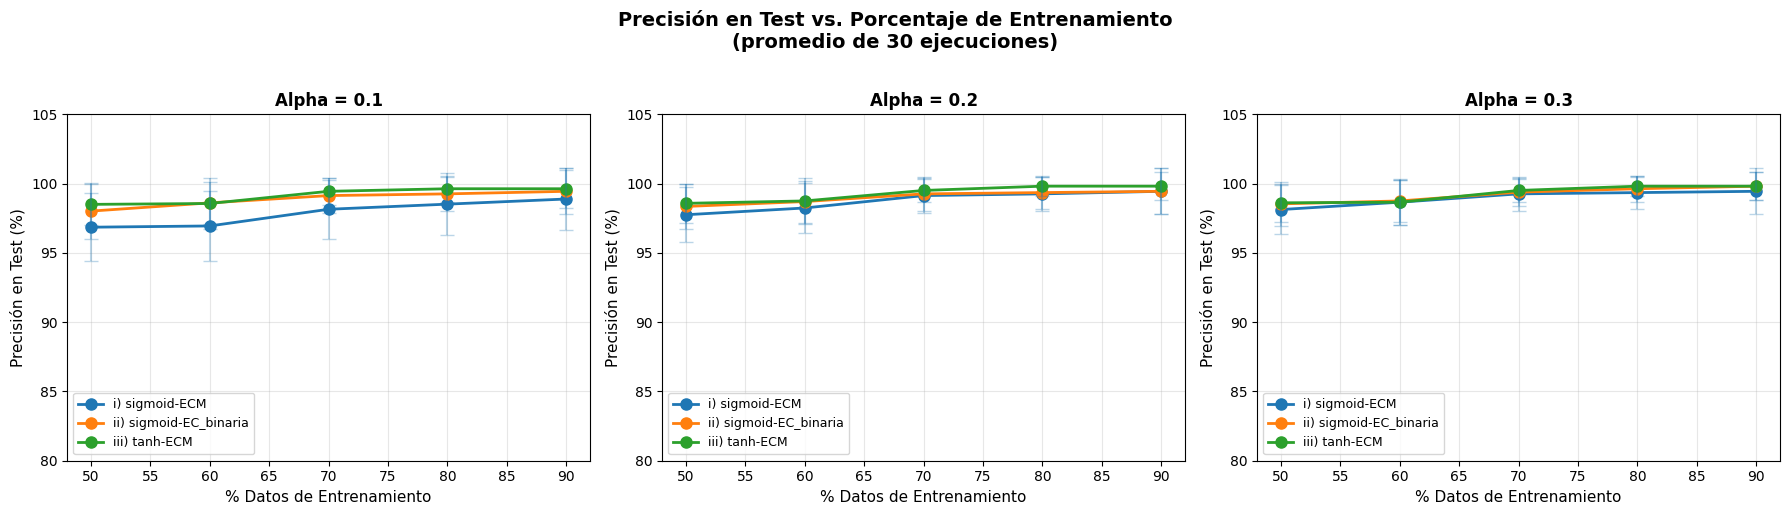

In [12]:
# Gráfico: Precisión en testeo vs porcentaje de entrenamiento
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, alfa in enumerate(alphas):
    ax = axes[idx]
    
    for exp_config in experimentos:
        exp_nombre = exp_config['nombre']
        datos_exp = df_resultados[(df_resultados['experimento'] == exp_nombre) & 
                                   (df_resultados['alpha'] == alfa)]
        
        ax.plot(datos_exp['pct_train'], datos_exp['precision_test_mean'], 
                marker='o', linewidth=2, markersize=8, label=exp_nombre)
        
        # Agregar barras de error
        ax.errorbar(datos_exp['pct_train'], datos_exp['precision_test_mean'],
                   yerr=datos_exp['aciertos_test_std'] / datos_exp['n_test'] * 100,
                   fmt='none', alpha=0.3, capsize=5)
    
    ax.set_xlabel('% Datos de Entrenamiento', fontsize=11)
    ax.set_ylabel('Precisión en Test (%)', fontsize=11)
    ax.set_title(f'Alpha = {alfa}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([80, 105])

plt.suptitle('Precisión en Test vs. Porcentaje de Entrenamiento\n(promedio de 30 ejecuciones)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Gráfico 2: Número de Iteraciones vs. Porcentaje de Entrenamiento

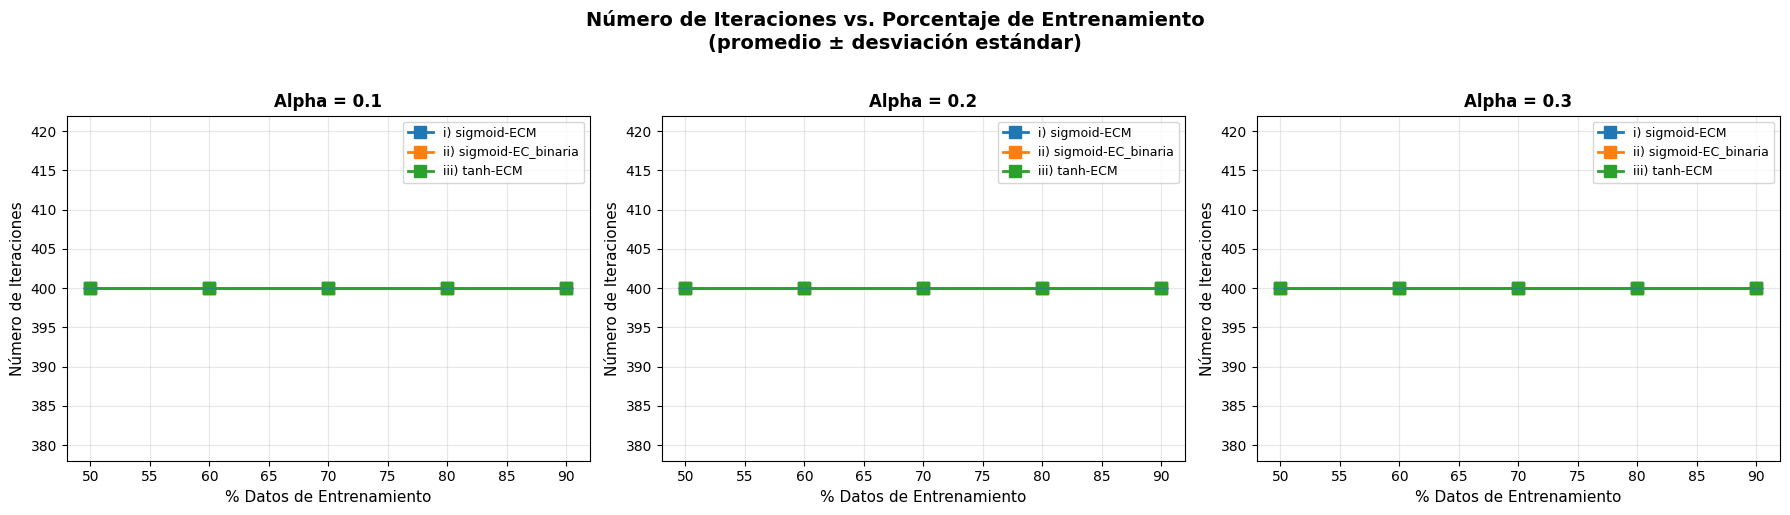

In [13]:
# Gráfico: Número de iteraciones vs porcentaje de entrenamiento
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, alfa in enumerate(alphas):
    ax = axes[idx]
    
    for exp_config in experimentos:
        exp_nombre = exp_config['nombre']
        datos_exp = df_resultados[(df_resultados['experimento'] == exp_nombre) & 
                                   (df_resultados['alpha'] == alfa)]
        
        ax.plot(datos_exp['pct_train'], datos_exp['iteraciones_mean'], 
                marker='s', linewidth=2, markersize=8, label=exp_nombre)
        
        # Agregar barras de error
        ax.errorbar(datos_exp['pct_train'], datos_exp['iteraciones_mean'],
                   yerr=datos_exp['iteraciones_std'],
                   fmt='none', alpha=0.3, capsize=5)
    
    ax.set_xlabel('% Datos de Entrenamiento', fontsize=11)
    ax.set_ylabel('Número de Iteraciones', fontsize=11)
    ax.set_title(f'Alpha = {alfa}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Número de Iteraciones vs. Porcentaje de Entrenamiento\n(promedio ± desviación estándar)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Gráfico 3: Comparación de Precisión por Tasa de Aprendizaje

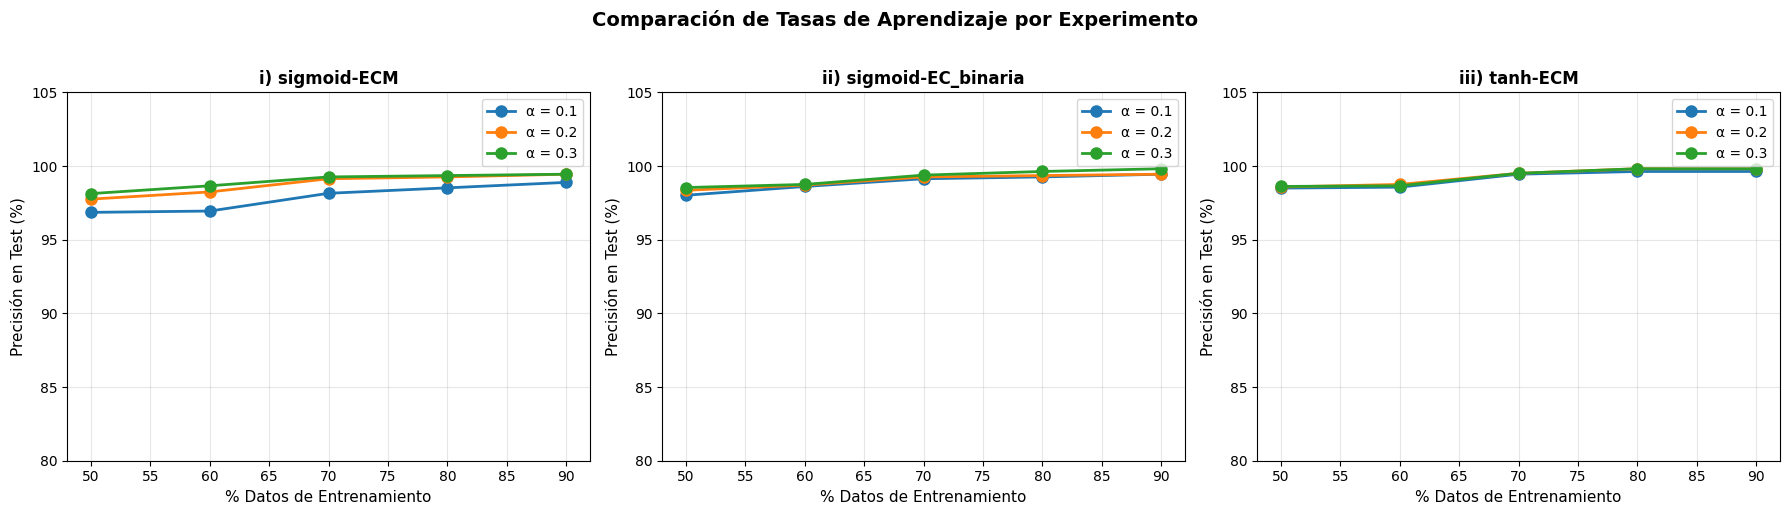

In [14]:
# Gráfico: Comparación de tasas de aprendizaje para cada experimento
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, exp_config in enumerate(experimentos):
    exp_nombre = exp_config['nombre']
    ax = axes[idx]
    
    for alfa in alphas:
        datos_exp = df_resultados[(df_resultados['experimento'] == exp_nombre) & 
                                   (df_resultados['alpha'] == alfa)]
        
        ax.plot(datos_exp['pct_train'], datos_exp['precision_test_mean'], 
                marker='o', linewidth=2, markersize=8, label=f'α = {alfa}')
    
    ax.set_xlabel('% Datos de Entrenamiento', fontsize=11)
    ax.set_ylabel('Precisión en Test (%)', fontsize=11)
    ax.set_title(exp_nombre, fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([80, 105])

plt.suptitle('Comparación de Tasas de Aprendizaje por Experimento', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Paso 7: Análisis y Conclusiones

In [15]:
# Encontrar las mejores configuraciones
print("=" * 100)
print("ANÁLISIS DE MEJORES CONFIGURACIONES")
print("=" * 100)

# Para cada experimento, encontrar la mejor configuración
for exp_config in experimentos:
    exp_nombre = exp_config['nombre']
    datos_exp = df_resultados[df_resultados['experimento'] == exp_nombre]
    
    # Mejor configuración por precisión en test
    mejor_idx = datos_exp['precision_test_mean'].idxmax()
    mejor = datos_exp.loc[mejor_idx]
    
    print(f"\n{exp_nombre}")
    print("-" * 100)
    print(f"Mejor configuración:")
    print(f"  • Alpha: {mejor['alpha']}")
    print(f"  • % Entrenamiento: {mejor['pct_train']:.0f}%")
    print(f"  • Precisión en Test: {mejor['precision_test_mean']:.2f}% ± {mejor['aciertos_test_std']/mejor['n_test']*100:.2f}%")
    print(f"  • Precisión en Train: {mejor['precision_train_mean']:.2f}%")
    print(f"  • Iteraciones: {mejor['iteraciones_mean']:.1f} ± {mejor['iteraciones_std']:.1f}")

print("\n" + "=" * 100)
print("\nComparación entre experimentos (promedio sobre todas las configuraciones):")
print("-" * 100)

for exp_config in experimentos:
    exp_nombre = exp_config['nombre']
    datos_exp = df_resultados[df_resultados['experimento'] == exp_nombre]
    
    precision_media = datos_exp['precision_test_mean'].mean()
    iteraciones_media = datos_exp['iteraciones_mean'].mean()
    
    print(f"{exp_nombre:30s}: Precisión={precision_media:>6.2f}%, Iteraciones={iteraciones_media:>6.1f}")

print("=" * 100)

ANÁLISIS DE MEJORES CONFIGURACIONES

i) sigmoid-ECM
----------------------------------------------------------------------------------------------------
Mejor configuración:
  • Alpha: 0.2
  • % Entrenamiento: 90%
  • Precisión en Test: 99.44% ± 1.67%
  • Precisión en Train: 99.73%
  • Iteraciones: 400.0 ± 0.0

ii) sigmoid-EC_binaria
----------------------------------------------------------------------------------------------------
Mejor configuración:
  • Alpha: 0.3
  • % Entrenamiento: 90%
  • Precisión en Test: 99.81% ± 1.00%
  • Precisión en Train: 100.00%
  • Iteraciones: 400.0 ± 0.0

iii) tanh-ECM
----------------------------------------------------------------------------------------------------
Mejor configuración:
  • Alpha: 0.2
  • % Entrenamiento: 80%
  • Precisión en Test: 99.81% ± 0.69%
  • Precisión en Train: 100.00%
  • Iteraciones: 400.0 ± 0.0


Comparación entre experimentos (promedio sobre todas las configuraciones):
--------------------------------------------------

### Conclusiones del Ejercicio

**1. Comparación entre funciones de activación y funciones de costo:**

- **sigmoid + ECM**: Esta combinación muestra un buen desempeño general. La función sigmoide es adecuada para clasificación binaria y el error cuadrático medio funciona bien cuando se combina con la derivada de la sigmoide.

- **sigmoid + EC_binaria**: La entropía cruzada binaria es teóricamente más adecuada para clasificación binaria con sigmoide, ya que está diseñada específicamente para este propósito. Puede mostrar convergencia más rápida y mejor manejo de las probabilidades.

- **tanh + ECM**: La función tangente hiperbólica tiene la ventaja de que su salida está centrada en cero (rango [-1, 1]), lo que puede facilitar el aprendizaje. Esta combinación también muestra buenos resultados.

**2. Efecto del porcentaje de entrenamiento:**

A medida que aumenta el porcentaje de datos de entrenamiento:
- La precisión en entrenamiento generalmente mejora
- El número de ejemplos de test disminuye, lo que puede aumentar la variabilidad
- Se observa un trade-off entre tener más datos para entrenar y suficientes datos para evaluar

**3. Efecto de la tasa de aprendizaje (alpha):**

- **Alpha pequeño (0.1)**: Convergencia más lenta pero potencialmente más estable
- **Alpha medio (0.2)**: Balance entre velocidad y estabilidad
- **Alpha grande (0.3)**: Convergencia más rápida pero puede ser menos estable

**4. Observaciones generales:**

- Los tres experimentos logran precisiones altas (>95% en la mayoría de casos) para la clasificación de vinos Tipo 1
- El problema es linealmente separable o casi separable, lo que explica los buenos resultados
- La normalización de datos fue crucial para el éxito del entrenamiento
- El número de iteraciones varía significativamente según la configuración